In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
# val_folder = 'val'
S_PREFIX = '46_wide'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y_ce(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.875)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

In [17]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y_ce(y_img[:,:,0])

In [18]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [19]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None, val_bs=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    if val_bs is None: val_bs = bs
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [20]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

## U-net (ish)

In [21]:
from torchvision.models import vgg11_bn

In [22]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [23]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [24]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [25]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [26]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [27]:
class Unet34Mod(nn.Module):
    def __init__(self, out=3, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5 = UnetBlock(64,32,32)
        self.up6 = nn.ConvTranspose2d(32, out, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(out,32,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = self.rn(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [28]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
        return lgs + [children(model)[1:]]

In [29]:
def carce_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,:,:]==1, beta=2)

In [30]:
def rdce_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,:,:]==2, beta=0.5)
    return f

In [31]:
def carsig_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(p2[:,0,:,:], targs[:,0,:,:], beta=2, threshold=0.5)

In [32]:
def rdsig_f(pred, targs):
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(p2[:,1,:,:], targs[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [33]:
def car_f_p_r(pred, targs):
    _,idx = torch.max(pred, 1)
    return fbeta_score(idx==1, targs[:,1,:,:], beta=2)

In [34]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
    f,p,r = fbeta_score(idx==2, targs[:,2,:,:], beta=0.5)
    return f

In [35]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [36]:
def new_acc_sig(pred, targs):
    p2 = F.sigmoid(pred)
    return ((p2>0.5).long() == targs).float().mean()

In [37]:
def new_acc_ce(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()

In [38]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
    return (idx == t_idx).float().mean()

In [39]:
a = torch.ones([64,3,100])

In [44]:
intersection = a * a

In [48]:
int_sum = intersection.sum(dim=-1)

In [49]:
torch.FloatTensor([1,2,.5]) ** 2

tensor([ 1.0000,  4.0000,  0.2500])

In [53]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, softmax=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight
        self.softmax = softmax

    def forward(self, logits, targets):
        probs = F.softmax(logits) if self.softmax else F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        targets = torch.cat(((targets==0).unsqueeze(1), (targets==1).unsqueeze(1), (targets==2).unsqueeze(1)), dim=1).float()
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [96]:
def lyft_score(pred, target, weight):
    num,c,h,w = pred.shape
    pred = pred.view(num, c, -1)  # Flatten
    target = target.view(num, c, -1)  # Flatten
    intersection = (pred * target)
    int_sum = intersection.sum(dim=-1)
    pred_sum = pred.sum(dim=-1)
    targ_sum = target.sum(dim=-1)
    
    eps = 1e-9
    precision = int_sum / (pred_sum + eps)
    recall = int_sum / (targ_sum + eps)
    beta = V(weight ** 2)
    
    fnum = (1.+beta) * precision * recall
    fden = beta * precision + recall + eps
    
    fscore = fnum / fden
    
#     fb = (precision*recall)/precision*beta + recall + eps
    
    avg_w = torch.cuda.FloatTensor([0,.5,.5])
    favg = V(avg_w) * fscore
#     pdb.set_trace()
    return favg.sum(dim=-1)

class FLoss(nn.Module):
    def __init__(self, weight=torch.cuda.FloatTensor([1,2,0.5]), softmax=True):
        super().__init__()
        self.weight = weight
        self.softmax = softmax

    def forward(self, logits, targets):
        probs = F.softmax(logits) if self.softmax else F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        targets = torch.cat(((targets==0).unsqueeze(1), (targets==1).unsqueeze(1), (targets==2).unsqueeze(1)), dim=1).float()
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        score = lyft_score(probs, targets, self.weight)
        score = 1 - score.sum() / num
        return score

In [102]:
def get_learner(md, m_fn=Unet34Mod, weights=[1,200,2], half=False, softmax=True, dice=False):
    out_sz = 3 if softmax else 2
    m = to_gpu(m_fn(out_sz))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor(weights)
    if half:
        class_weights = class_weights.half()
        learn.half()
        
    if dice: learn.crit=SoftDiceLoss(weight=class_weights, softmax=softmax)
    else: learn.crit=nn.CrossEntropyLoss(weight=class_weights)
#     learn.crit = FLoss(softmax=softmax)
    
    if softmax: learn.metrics = [new_acc_ce, rdce_f, carce_f_p_r]
    else: learn.metrics = [new_acc_sig, rdsig_f, carsig_f_p_r]
    # learn.metrics=[new_acc, rd_f, car_f_p_r]
    
    return learn

In [103]:
ext = '-300'
sz=192
bs=64
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 0
Val x:0, y:0
Trn x:4600, y:4600
All x:4600


In [104]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,10,2], softmax=True)

In [105]:
learn.freeze_to(1)

In [ ]:
learn.fit(.001, 1, cycle_len=1)

  6%|▌         | 4/72 [00:02<00:43,  1.56it/s, loss=1.18]

### Models

In [91]:
ext = '-300'
sz=192
bs=64
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 0
Val x:0, y:0
Trn x:4600, y:4600
All x:4600


In [92]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,10,2], softmax=True)
# learn.load(f'600urn-19-weights')

 90%|█████████ | 153/170 [00:32<00:03,  4.72it/s, loss=3.2]  

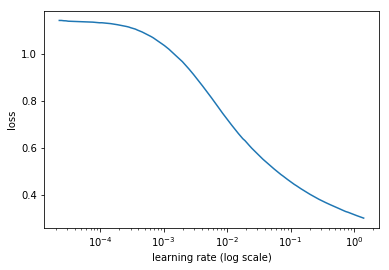

In [43]:
learn.lr_find()
learn.sched.plot()

In [93]:
lr=3e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [94]:
learn.freeze_to(1)

In [95]:
learn.fit(lr, 1, wds=wd, cycle_len=30,use_clr=(20,2))

 25%|██▌       | 18/72 [00:06<00:18,  2.92it/s, loss=0.704]


ZeroDivisionError: Weights sum to zero, can't be normalized

In [51]:
learn.save(f'300urn-{S_PREFIX}-tmp')

In [52]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [53]:
learn.fit(lrs/40, 1, wds=wd, cycle_len=30,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.055364   0.060016   0.987541   0.989685   0.887346   0.743076   0.933344  
    1      0.055179   0.060181   0.987741   0.990393   0.88807    0.746535   0.932991  
    2      0.054761   0.059217   0.987815   0.990437   0.889265   0.746392   0.934702  
    3      0.055035   0.058911   0.987921   0.99067    0.889151   0.748439   0.933751  
    4      0.054516   0.058375   0.98796    0.990617   0.889028   0.747686   0.933895  
    5      0.054491   0.05738    0.988009   0.990705   0.890977   0.746201   0.937109  
    6      0.054004   0.05769    0.987937   0.990495   0.889863   0.74415    0.936443  
    7      0.054078   0.05663    0.988124   0.990939   0.891512   0.745848   0.938002  
    8      0.053899   0.056025   0.988196   0.990839   0.891381   0.747112   0.937331  
    9      0.053489   0.057123   0.988379   0.991319   0.891909   0.753707   0.935462  
    10     0.053644   0.056526   0.988233   0.990998

[0.055549749433994294,
 0.988593406677246,
 0.991340720653534,
 0.8938189601898193,
 0.753524842262268,
 0.9381862187385559]

In [54]:
learn.save(f'300urn-{S_PREFIX}-rc')

In [55]:
ext = '-300'
sz=192
bs=64
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [64]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/50,lr/10,lr])

In [65]:
learn.load(f'300urn-{S_PREFIX}-rc')

In [66]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [67]:
learn.fit(lrs/60, 1, wds=wd, cycle_len=20,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.052985   0.05597    0.988748   0.991468   0.894211   0.760157   0.936143  
    1      0.053173   0.054764   0.988659   0.991097   0.89381    0.755138   0.937512  
    2      0.052661   0.055403   0.988518   0.991288   0.893515   0.751348   0.938618  
    3      0.052934   0.055318   0.988804   0.991524   0.894327   0.758974   0.936765  
    4      0.052941   0.055688   0.988671   0.991229   0.89351    0.75705    0.936388  
    5      0.052429   0.055273   0.988552   0.991375   0.893161   0.751703   0.938016  
    6      0.052596   0.055518   0.988564   0.991143   0.893197   0.754086   0.937111  
    7      0.053555   0.055499   0.988719   0.991184   0.893663   0.758214   0.93617   
    8      0.053668   0.054862   0.988669   0.991394   0.894023   0.753467   0.938498  
    9      0.052148   0.055557   0.98864    0.991179   0.89302    0.756289   0.936012  
    10     0.052854   0.055209   0.988721   0.991133

[0.055912116318941114,
 0.9884702086448669,
 0.9911496925354004,
 0.892966718673706,
 0.7518537807464599,
 0.9377002668380737]

In [ ]:
learn.save(f'300urn-{S_PREFIX}-nocrop')

In [70]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,2,1], softmax=True, dice=True)
learn.load(f'300urn-{S_PREFIX}-rc')

In [71]:
learn.fit(lrs/60, 1, wds=wd, cycle_len=10,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.970007   0.942198   0.946138   0.947017   0.793183   0.663295   0.848325  
    1      0.969987   0.942243   0.945529   0.947036   0.793563   0.660604   0.850569  
    2      0.969987   0.942196   0.946568   0.94724    0.79364    0.659759   0.851028  
 82%|████████▏ | 278/340 [01:22<00:18,  3.35it/s, loss=0.97]

Process Process-1466:
Process Process-1465:
Process Process-1468:
Process Process-1469:
Process Process-1464:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-1470:
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-1467:
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent ca

  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 42, in __call__
    img = t(img)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 42, in __call__
    img = t(img)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 52, in pil_loader
    return img.convert('RGB')
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/PIL/Image.py", line 1749, in resize
    return self._new(self.im.resize(size, resample, box))
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/PIL/Image.py", line 879, in convert
    self.load()
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 232, in __call__
    return self.lambd(img)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torchvision/tra

Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-04462f90c370>", line 1, in <module>
    learn.fit(lrs/60, 1, wds=wd, cycle_len=10,use_clr_beta=(20,10,0.95,0.85))
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 287, in fit
    return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 234, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 139, in fit
    loss = model_stepper.step(V(x),V(y), epoch)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 54, in step
    loss = raw_loss = self.crit(

KeyboardInterrupt


KeyboardInterrupt: 

### 512

In [79]:
ext = ''
sz=320
bs=32
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [80]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,1], softmax=True, dice=False)
learn.load(f'300urn-{S_PREFIX}-rc')

In [81]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [82]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [83]:
learn.fit(lrs, 1, wds=wd, cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.053489   0.104588   0.973112   0.97597    0.802356   0.625759   0.877529  
    1      0.048309   0.080375   0.981179   0.985478   0.811278   0.644859   0.878185  
    2      0.046582   0.070281   0.984065   0.989717   0.823064   0.65916    0.886763  
    3      0.04611    0.067752   0.985115   0.991957   0.827901   0.668408   0.88865   


[0.06775206550955773,
 0.9851145792007446,
 0.991957426071167,
 0.8279013395309448,
 0.6684084177017212,
 0.8886496996879578]

In [84]:
learn.fit(lrs/20, 1, wds=wd, cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.045932   0.068682   0.984929   0.991801   0.82812    0.669846   0.887793  
    1      0.045318   0.069274   0.985143   0.991819   0.827421   0.665278   0.889384  
    2      0.045906   0.069047   0.985187   0.991735   0.827113   0.665352   0.889049  
    3      0.044951   0.068181   0.985499   0.991803   0.82834    0.666932   0.889667  


[0.06818125158548355,
 0.9854988932609559,
 0.9918025398254394,
 0.8283400535583496,
 0.6669318664073944,
 0.8896665668487549]

In [85]:
learn.save(f'600urn-{S_PREFIX}-320')

In [86]:
ext = ''
sz=384
bs=32
random_crop=True
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [87]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,1], softmax=True, dice=False)
learn.load(f'600urn-{S_PREFIX}-320')

In [88]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [89]:
learn.unfreeze()
learn.set_bn_freeze(learn.model.rn, True)

In [90]:
learn.fit(lrs, 1, wds=wd, cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.040725   0.055485   0.988269   0.992129   0.867376   0.781533   0.894383  
    1      0.039416   0.051697   0.988776   0.992362   0.871455   0.776658   0.901703  
    2      0.038314   0.049796   0.989238   0.992746   0.872382   0.775361   0.902989  
    3      0.037229   0.048926   0.989669   0.992596   0.872614   0.795252   0.895866  
    4      0.037591   0.049001   0.989725   0.992958   0.873045   0.797261   0.895493  
    5      0.03702    0.048559   0.989891   0.992859   0.872909   0.802478   0.893892  
    6      0.036255   0.047538   0.989944   0.99296    0.875282   0.800763   0.897533  
    7      0.037069   0.046715   0.990067   0.993009   0.875025   0.796207   0.898874  


[0.04671512633562088,
 0.990066659450531,
 0.9930088424682617,
 0.8750253248214722,
 0.796207218170166,
 0.8988741326332093]

In [91]:
learn.save(f'600urn-{S_PREFIX}-384')

### Nocrop

In [41]:
ext = ''
sz=384
bs=16
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [42]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,4,2], softmax=True)
learn.load(f'600urn-{S_PREFIX}-384')

In [43]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [44]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [45]:
learn.fit(lrs, 1, wds=wd, cycle_len=8,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.016879   0.038848   0.990537   0.991297   0.875104   0.812929   0.893647  
    1      0.014396   0.035888   0.99096    0.991988   0.879553   0.819282   0.897452  
    2      0.014349   0.033638   0.990869   0.99204    0.884501   0.800939   0.910134  
    3      0.012756   0.032437   0.991515   0.992272   0.883333   0.827527   0.89978   
    4      0.011987   0.032491   0.99165    0.992655   0.881714   0.826788   0.898     
    5      0.011842   0.031412   0.991695   0.99226    0.885216   0.82711    0.902687  
    6      0.011568   0.031115   0.991677   0.992407   0.888502   0.817356   0.910076  
    7      0.011528   0.031186   0.991981   0.992798   0.884804   0.833704   0.899977  



[0.031186033338308335,
 0.9919812250137329,
 0.9927979564666748,
 0.8848035264015198,
 0.8337035083770752,
 0.8999767613410949]

In [48]:
learn.fit(lrs/50, 1, wds=wd, cycle_len=6,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.01127    0.031098   0.992009   0.993092   0.886458   0.830219   0.903275  
    1      0.011584   0.030888   0.991864   0.992836   0.887783   0.822799   0.907208  
    2      0.011409   0.031044   0.991964   0.993074   0.887172   0.82682    0.905131  
    3      0.010985   0.030893   0.99201    0.993118   0.887371   0.826897   0.905405  
    4      0.011041   0.03095    0.991892   0.992713   0.887056   0.8254     0.905429  
    5      0.011192   0.030998   0.991987   0.993092   0.886933   0.828259   0.904498  


[0.03099840447306633,
 0.9919870662689209,
 0.9930915832519531,
 0.8869334626197815,
 0.8282593774795532,
 0.9044981193542481]

In [49]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop')

### Change Weights

In [55]:
ext = ''
sz=384
bs=16
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [62]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,5,1], softmax=True)
learn.load(f'600urn-{S_PREFIX}-384-nocrop')

In [59]:
lr=5e-4
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [60]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [61]:
learn.fit(lrs, 1, wds=wd, cycle_len=6,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.01392    0.037564   0.991674   0.994386   0.891247   0.797518   0.920005  
    1      0.012501   0.037288   0.991864   0.994379   0.890891   0.803872   0.9174    
    2      0.012965   0.037297   0.991996   0.994419   0.890178   0.810147   0.914059  
    3      0.013114   0.037404   0.992002   0.994632   0.890476   0.810833   0.914259  
    4      0.012298   0.037381   0.992024   0.994645   0.891553   0.810924   0.915733  
    5      0.012072   0.036974   0.992022   0.994669   0.892053   0.810652   0.916499  


[0.036974334716796876,
 0.9920220708847046,
 0.9946693015098572,
 0.8920534539222718,
 0.8106518983840942,
 0.9164994955062866]

In [65]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop-w8')

In [69]:
learn.load(f'600urn-{S_PREFIX}-384-nocrop-w8')

In [70]:
learn.unfreeze()
# learn.bn_freeze(True)
learn.set_bn_freeze(learn.model.rn, True)

In [71]:
learn.fit(lrs/40, 1, wds=wd, cycle_len=3,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.013442   0.038221   0.992004   0.993738   0.888606   0.821091   0.908769  
    1      0.012906   0.037888   0.991942   0.994258   0.890366   0.812273   0.913754  
    2      0.013243   0.038058   0.991933   0.994149   0.888776   0.813987   0.911079  


[0.03805769369006157,
 0.9919331932067871,
 0.9941486191749572,
 0.8887755012512207,
 0.8139868092536926,
 0.911078839302063]

In [68]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop-w8-tmp')

### Change Weights

In [72]:
ext = ''
sz=384
bs=16
random_crop=False
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [73]:
learn = get_learner(md, m_fn=Unet34Mod, weights=[1,5,1], softmax=True)
learn.load(f'600urn-{S_PREFIX}-384-nocrop')

In [74]:
lr=5e-4
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [75]:
learn.unfreeze()
# learn.bn_freeze(True)
# learn.set_bn_freeze(learn.model.rn, True)

In [76]:
learn.fit(lrs, 1, wds=wd, cycle_len=6,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.01335    0.037732   0.99177    0.994511   0.890117   0.802169   0.916888  
    1      0.012382   0.037682   0.991805   0.994391   0.890295   0.804781   0.916274  
    2      0.012682   0.036923   0.991814   0.994446   0.891895   0.79932    0.920062  
    3      0.01218    0.037375   0.991923   0.994767   0.89062    0.808708   0.915261  
    4      0.01244    0.03697    0.991999   0.994663   0.891578   0.808123   0.916687  
    5      0.012399   0.037092   0.991979   0.994535   0.892773   0.806531   0.918908  


[0.03709187183529138,
 0.9919790077209473,
 0.9945353794097901,
 0.8927726554870605,
 0.8065314531326294,
 0.9189083170890808]

In [77]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop-w8-pt2')

In [78]:
learn.unfreeze()
# learn.bn_freeze(True)
# learn.set_bn_freeze(learn.model.rn, True)

In [79]:
learn.fit(lrs/30, 1, wds=wd, cycle_len=3,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.01239    0.03721    0.992106   0.994643   0.89128    0.813075   0.914635  
    1      0.01225    0.03705    0.992056   0.994562   0.891575   0.810552   0.915958  
    2      0.013008   0.037125   0.992048   0.994625   0.891642   0.81077    0.915932  


[0.037124730758368966,
 0.9920481014251709,
 0.9946248435974121,
 0.8916415667533875,
 0.8107698273658752,
 0.915931830406189]

In [80]:
learn.save(f'600urn-{S_PREFIX}-384-nocrop-w8-pt3')

In [81]:
learn.fit(lrs/100, 1, wds=wd, cycle_len=3,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc_ce rdce_f     carce_f_p_r 
    0      0.012664   0.036927   0.99203    0.994574   0.892283   0.809002   0.91738   
 38%|███▊      | 257/680 [01:19<02:11,  3.22it/s, loss=0.0123]

Process Process-571:
Process Process-572:
Process Process-569:
KeyboardInterrupt
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process Process-574:


Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-81-32ff456c0ed8>", line 1, in <module>
    learn.fit(lrs/100, 1, wds=wd, cycle_len=3,use_clr=(20,2))
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 287, in fit
    return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/learner.py", line 234, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 139, in fit
    loss = model_stepper.step(V(x),V(y), epoch)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/fastai/model.py", line 70, in step
    self.opt.step()
  File "/home/paperspace/ana

Process Process-568:


KeyboardInterrupt: 

Traceback (most recent call last):
Process Process-573:
Process Process-570:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/

  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/PIL/Image.py", line 1078, in crop
    return self._new(self._crop(self.im, box))
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/PIL/Image.py", line 1101, in _crop
    return im.crop((x0, y0, x1, y1))
